In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class MeanReversionStrategy:
    def __init__(self, window=20, k=2):
        """
        Initialize the mean reversion strategy.

        Parameters:
        - window (int): Rolling window size for calculating the moving average and standard deviation.
        - k (float): Number of standard deviations for signal threshold.
        """
        self.window = window
        self.k = k

    def calculate_indicators(self, data, factor_column):
        """
        Calculate rolling mean, standard deviation, and thresholds for the strategy.

        Parameters:
        - data (pd.DataFrame): Preprocessed DataFrame.
        - factor_column (str): The name of the column with factor returns.

        Returns:
        - pd.DataFrame: DataFrame with added columns for Mean, Std, Upper_Threshold, and Lower_Threshold.
        """
        data['Mean'] = data[factor_column].rolling(self.window).mean()
        data['Std'] = data[factor_column].rolling(self.window).std()
        data['Upper_Threshold'] = data['Mean'] + self.k * data['Std']
        data['Lower_Threshold'] = data['Mean'] - self.k * data['Std']
        return data

    def generate_signals(self, data, factor_column):
        """
        Generate trading signals based on the calculated thresholds.

        Parameters:
        - data (pd.DataFrame): DataFrame with calculated indicators.
        - factor_column (str): The name of the column with factor returns.

        Returns:
        - pd.DataFrame: DataFrame with added Signal column.
        """
        data['Signal'] = 0
        data.loc[data[factor_column] > data['Upper_Threshold'], 'Signal'] = -1  # Short signal
        data.loc[data[factor_column] < data['Lower_Threshold'], 'Signal'] = 1   # Long signal
        return data

    def track_positions(self, data):
        """
        Track positions based on the generated signals.
        - Long position is held when Signal = 1.
        - Position is exited when Signal = -1.

        Returns a column `Position` indicating holding periods.
        """
        data['Position'] = 0  # Initialize position column

        for i in range(1, len(data)):
            if data.iloc[i]['Signal'] == 1:  # Enter long position
                data.iloc[i, data.columns.get_loc('Position')] = 1
            elif data.iloc[i]['Signal'] == -1:  # Exit position
                data.iloc[i, data.columns.get_loc('Position')] = 0
            else:
                # Continue holding the previous position if no signal
                data.iloc[i, data.columns.get_loc('Position')] = data.iloc[i - 1, data.columns.get_loc('Position')]

        return data

    def calculate_returns(self, data, factor_column):
        """
        Calculate strategy returns.

        Parameters:
        - data (pd.DataFrame): DataFrame with generated signals.
        - factor_column (str): The name of the column with factor returns.

        Returns:
        - pd.DataFrame: DataFrame with Strategy_Returns column.
        """
        data['Strategy_Returns'] = data['Position'].shift(1) * data[factor_column]
        return data

    def apply_strategy(self, data, factor_column):
        """
        Apply the full mean reversion strategy to the dataset.

        Parameters:
        - data (pd.DataFrame): Input DataFrame containing a Date column and factor return column.
        - factor_column (str): The name of the column with factor returns.

        Returns:
        - pd.DataFrame: DataFrame with calculated indicators, signals, and returns.
        """
        data = self.calculate_indicators(data, factor_column)
        data = self.generate_signals(data, factor_column)
        data = self.track_positions(data)
        data = self.calculate_returns(data, factor_column)
        return data

In [3]:
class MeanReversionPlotter:
    def plot_results(self, data, factor_column):
        """
        Plot the factor returns, thresholds, cumulative returns, and portfolio returns.

        Parameters:
        - data (pd.DataFrame): DataFrame with calculated indicators and returns.
        - factor_column (str): The name of the column with factor returns.
        """
        # Plot Factor Returns, Mean, and Thresholds
        plt.figure(figsize=(12, 6))
        plt.plot(data['Date'], data[factor_column], label='Factor Returns')
        plt.plot(data['Date'], data['Mean'], label='Rolling Mean', linestyle='--')
        plt.plot(data['Date'], data['Upper_Threshold'], label='Upper Threshold', linestyle=':')
        plt.plot(data['Date'], data['Lower_Threshold'], label='Lower Threshold', linestyle=':')
        plt.title("Mean Reversion Strategy Using Factor Returns")
        plt.xlabel("Date")
        plt.ylabel("Factor Returns")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot Cumulative Returns
        plt.figure(figsize=(12, 6))
        plt.plot(data['Date'], data['Cumulative_Returns'], label="Cumulative Returns", color="green")
        plt.title("Cumulative Returns of Mean Reversion Strategy")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Returns")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot Portfolio Returns
        plt.figure(figsize=(12, 6))
        plt.plot(data['Date'], data['Strategy_Returns'], label="Portfolio Daily Returns", color="blue", alpha=0.7)
        plt.title("Portfolio Returns (Daily)")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Returns")
        plt.legend()
        plt.grid(True)
        plt.show()

    def print_performance_metrics(self, performance_metrics):
        """
        Print the performance metrics.

        Parameters:
        - performance_metrics (dict): Dictionary containing performance metrics.
        """
        print("Performance Metrics:")
        for key, value in performance_metrics.items():
            print(f"{key}: {value:.4f}")

In [4]:
class StrategyReturnExtractor:
    def __init__(self, strategy_class):
        """
        Initialize the extractor with a strategy class.

        Parameters:
        - strategy_class: An instance of a strategy class, e.g., MeanReversionStrategy.
        """
        self.strategy_class = strategy_class

    def extract_strategy_returns(self, data, factor_column):
        """
        Apply the strategy and return only the strategy returns.

        Parameters:
        - data (pd.DataFrame): Input DataFrame containing a Date column and factor return column.
        - factor_column (str): The name of the column with factor returns.

        Returns:
        - pd.DataFrame: DataFrame with Date and Strategy_Returns columns.
        """
        processed_data = self.strategy_class.apply_strategy(data.copy(), factor_column)
        return processed_data[['Date', 'Strategy_Returns']]

### Hang Seng

In [5]:
# Load the datasets
asia_returns = pd.read_csv("asia_returns.csv")
asia_tickers = pd.read_csv("asia_tickers.csv")

# Step 1: Extract tickers and ensure unique column names
asia_returns = asia_returns.loc[:, ~asia_returns.columns.duplicated()]  # Remove duplicates
tickers = asia_tickers['Ticker']  # Assuming the 'Ticker' column contains the ticker names

# Rename columns in asia_returns to ensure the first column is 'Date' and others are tickers
asia_returns.columns = ['Date'] + tickers.tolist()
asia_returns['Date'] = pd.to_datetime(asia_returns['Date'])
asia_returns.dropna(inplace=True)
asia_returns

,Date,360,A2M,ABC,ADH,AGL,AKE,ALL,ALQ,ALU,...,9873,9882,9948,9956,9962,9983,9984,9987,9989,167A
0,2022-11-02,-0.002954,0.013462,0.026946,0.036866,0.015449,-0.039229,-0.010074,-0.008540,-0.002776,...,-0.000362,-0.010609,0.010137,0.004079,-0.015773,-0.001203,0.019927,-0.022590,0.011645,0.023433
1,2022-11-03,0.002963,0.041746,-0.049563,-0.031111,-0.020747,-0.024913,0.000803,-0.021533,-0.007795,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2022-11-04,0.014771,-0.012750,0.006135,0.032110,0.029661,0.060326,-0.005619,-0.005282,0.006734,...,0.011236,-0.020880,-0.008028,-0.012188,-0.027244,-0.004221,-0.022073,-0.016949,-0.020144,0.014208
3,2022-11-07,-0.016012,0.016605,0.009146,-0.017778,0.017833,0.001339,-0.004306,0.004425,-0.044872,...,-0.002151,-0.001729,0.000000,0.017039,0.037891,0.015015,0.006710,0.007837,-0.004405,-0.000379
4,2022-11-08,-0.041420,0.039927,0.006042,0.013575,0.018868,0.033422,-0.000811,-0.000881,0.000584,...,-0.005029,0.007506,0.009611,0.008088,0.009524,-0.004058,0.049689,0.012442,0.007375,0.015056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,2024-11-06,0.030895,-0.029197,0.000000,0.051169,-0.004713,0.000000,0.011532,0.026518,0.000000,...,0.000000,-0.005115,-0.005619,0.000452,0.012659,0.025457,0.051313,-0.023201,-0.017013,0.006353
508,2024-11-07,0.003967,-0.024436,0.000000,-0.026201,0.000000,0.000000,0.000316,0.006120,0.000000,...,0.000000,0.001974,0.014088,0.018678,-0.032946,-0.032969,-0.019465,0.018757,0.000806,0.005880
509,2024-11-08,0.044337,0.017341,0.000000,-0.003859,0.005684,0.000000,0.019630,0.000672,0.000000,...,0.000000,-0.007919,-0.006363,-0.013141,0.004205,0.011502,0.015836,0.003879,-0.002391,-0.005451
510,2024-11-11,0.006726,-0.068182,0.000000,-0.015424,-0.006595,0.000000,0.018631,0.012157,0.000000,...,0.000000,-0.016789,-0.012352,0.001440,-0.007173,0.004670,0.015473,-0.006316,-0.015998,-0.075828


In [22]:
output_file = "asia_returns_processed.xlsx"
asia_returns.to_excel(output_file, index=False)
output_file

'asia_returns_processed.xlsx'

In [6]:
class MeanReversionStrategySimple:
    def __init__(self, window=20, k=2):
        self.window = window
        self.k = k

    def apply_strategy(self, data, factor_column):
        """
        Apply mean reversion strategy to a single ticker's data.
        """
        data['Mean'] = data[factor_column].rolling(self.window).mean()
        data['Std'] = data[factor_column].rolling(self.window).std()
        data['Upper_Threshold'] = data['Mean'] + self.k * data['Std']
        data['Lower_Threshold'] = data['Mean'] - self.k * data['Std']
        data['Signal'] = 0
        data.loc[data[factor_column] > data['Upper_Threshold'], 'Signal'] = -1
        data.loc[data[factor_column] < data['Lower_Threshold'], 'Signal'] = 1
        data['Position'] = data['Signal'].shift(1).fillna(0).cumsum()
        data['Strategy_Returns'] = data['Position'].shift(1) * data[factor_column]
        return data[['Date', 'Strategy_Returns']]

In [7]:
strategy_20 = MeanReversionStrategy(window=20, k=2)
strategy_50 = MeanReversionStrategy(window=50, k=2)
strategy_90 = MeanReversionStrategy(window=90, k=2)

In [8]:
strategy_results = {}
for ticker in asia_returns.columns[1:]:
    # Prepare the data for the current ticker
    ticker_data = asia_returns[['Date', ticker]].copy()
    ticker_data.rename(columns={ticker: 'Factor_Return'}, inplace=True)

    # Debugging: Verify the structure of ticker_data
    if ticker_data.shape[1] != 2:
        print(f"Error: Unexpected structure for ticker {ticker}, DataFrame shape: {ticker_data.shape}")
        continue

    # Debugging: Print the head of ticker_data to ensure it's structured properly
    print(f"Processing ticker: {ticker}")
    print(ticker_data.head())

    # Ensure the column contains numeric data
    try:
        ticker_data['Factor_Return'] = pd.to_numeric(ticker_data['Factor_Return'], errors='coerce')
        ticker_data.dropna(inplace=True)  # Drop rows with missing or invalid values
    except Exception as e:
        print(f"Error cleaning Factor_Return for ticker {ticker}: {e}")
        continue

    # Apply the strategy
    try:
        processed_data = strategy_50.apply_strategy(ticker_data, 'Factor_Return')
        strategy_results[ticker] = processed_data.set_index('Date')['Strategy_Returns']
    except Exception as e:
        print(f"Error applying strategy for ticker {ticker}: {e}")
        continue

# Combine all results into a single DataFrame
final_strategy_df = pd.concat(strategy_results, axis=1)

# Display the combined strategy returns
final_strategy_df.head()


Processing ticker: 360
        Date  Factor_Return
0 2022-11-02      -0.002954
1 2022-11-03       0.002963
2 2022-11-04       0.014771
3 2022-11-07      -0.016012
4 2022-11-08      -0.041420
Processing ticker: A2M
        Date  Factor_Return
0 2022-11-02       0.013462
1 2022-11-03       0.041746
2 2022-11-04      -0.012750
3 2022-11-07       0.016605
4 2022-11-08       0.039927
Processing ticker: ABC
        Date  Factor_Return
0 2022-11-02       0.026946
1 2022-11-03      -0.049563
2 2022-11-04       0.006135
3 2022-11-07       0.009146
4 2022-11-08       0.006042
Processing ticker: ADH
        Date  Factor_Return
0 2022-11-02       0.036866
1 2022-11-03      -0.031111
2 2022-11-04       0.032110
3 2022-11-07      -0.017778
4 2022-11-08       0.013575
Processing ticker: AGL
        Date  Factor_Return
0 2022-11-02       0.015449
1 2022-11-03      -0.020747
2 2022-11-04       0.029661
3 2022-11-07       0.017833
4 2022-11-08       0.018868
Processing ticker: AKE
        Date  Factor_R

,360,A2M,ABC,ADH,AGL,AKE,ALL,ALQ,ALU,AMC,...,9873,9882,9948,9956,9962,9983,9984,9987,9989,167A
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-03,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-04,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
2022-11-07,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
2022-11-08,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0


In [21]:
final_strategy_df

,360,A2M,ABC,ADH,AGL,AKE,ALL,ALQ,ALU,AMC,...,9882,9948,9956,9962,9983,9984,9987,9989,167A,Composite_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-03,0.000000,0.000000,-0.0,-0.0,-0.000000,-0.0,0.0,-0.000000,-0.0,-0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2022-11-04,0.000000,-0.000000,0.0,0.0,0.000000,0.0,-0.0,-0.000000,0.0,-0.000000,...,-0.0,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,0.000000,0.000000
2022-11-07,-0.000000,0.000000,0.0,-0.0,0.000000,0.0,-0.0,0.000000,-0.0,0.000000,...,-0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.0,-0.000000,0.000000
2022-11-08,-0.000000,0.000000,0.0,0.0,0.000000,0.0,-0.0,-0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,-0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-06,0.030895,-0.000000,0.0,0.0,-0.004713,0.0,0.0,0.026518,0.0,0.005785,...,-0.0,-0.005619,0.000452,0.0,0.0,0.0,-0.023201,-0.0,0.000000,0.000463
2024-11-07,0.003967,-0.000000,0.0,-0.0,0.000000,0.0,0.0,0.006120,0.0,-0.008311,...,0.0,0.014088,0.018678,-0.0,-0.0,-0.0,0.018757,0.0,0.000000,0.005482
2024-11-08,0.044337,0.000000,0.0,-0.0,0.005684,0.0,0.0,0.000672,0.0,-0.002581,...,-0.0,-0.006363,-0.013141,0.0,0.0,0.0,0.003879,-0.0,-0.000000,-0.001647


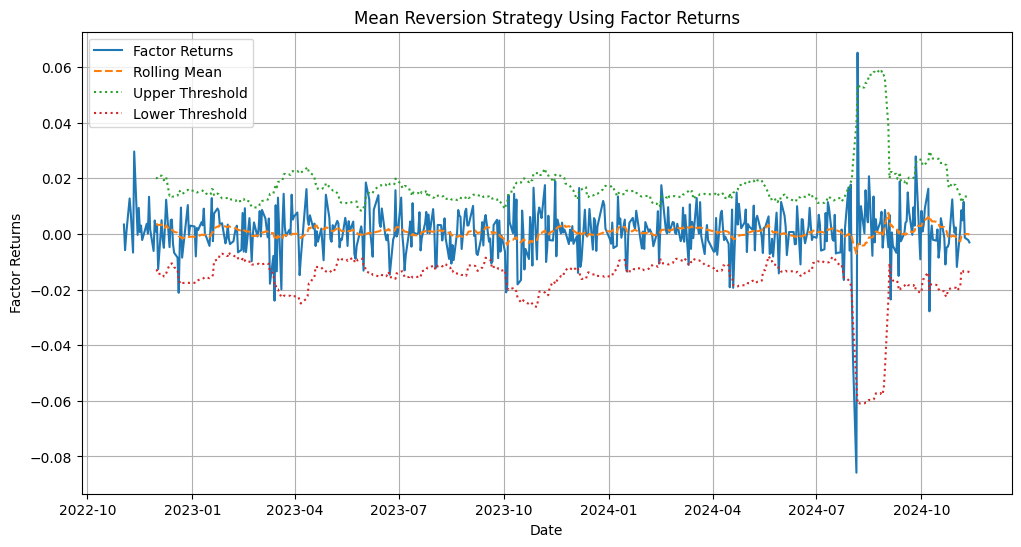

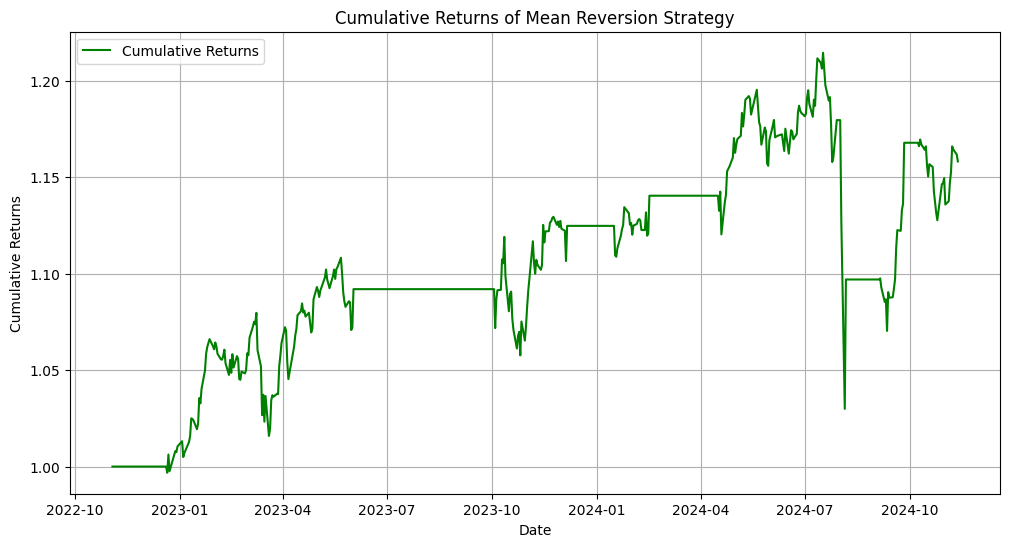

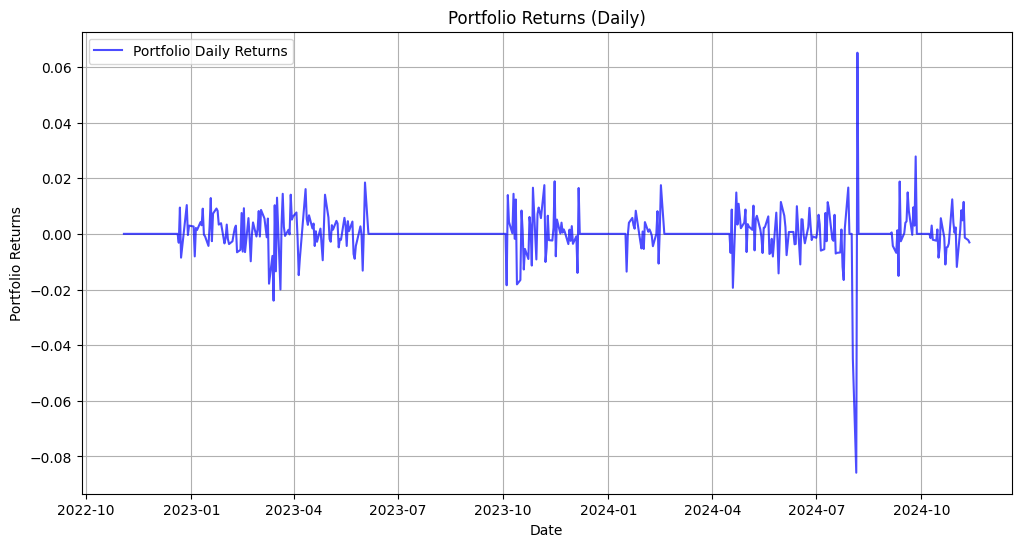

Performance Metrics:
Average Return: 0.0003
Standard Deviation: 0.0078
Sharpe Ratio: 0.0408


In [12]:
asia_returns['Composite_Returns'] = asia_returns[tickers].mean(axis=1)
composite_data = asia_returns[['Date', 'Composite_Returns']].dropna()
composite_data.columns = ['Date', 'Factor_Returns']  # Rename for compatibility

# Apply the strategy to the composite returns
composite_result_20 = strategy_20.apply_strategy(composite_data, factor_column='Factor_Returns')

# Calculate cumulative returns for composite_result
composite_result_20['Cumulative_Returns'] = (1 + composite_result_20['Strategy_Returns']).cumprod()

# Plot the results for the composite returns
plotter = MeanReversionPlotter()
plotter.plot_results(composite_result_20, factor_column='Factor_Returns')

# Compute and print performance metrics for composite returns
avg_return = composite_result_20['Strategy_Returns'].mean()
std_dev = composite_result_20['Strategy_Returns'].std()
sharpe_ratio = avg_return / std_dev if std_dev != 0 else np.nan

performance_metrics = {
    "Average Return": avg_return,
    "Standard Deviation": std_dev,
    "Sharpe Ratio": sharpe_ratio
}

plotter.print_performance_metrics(performance_metrics)

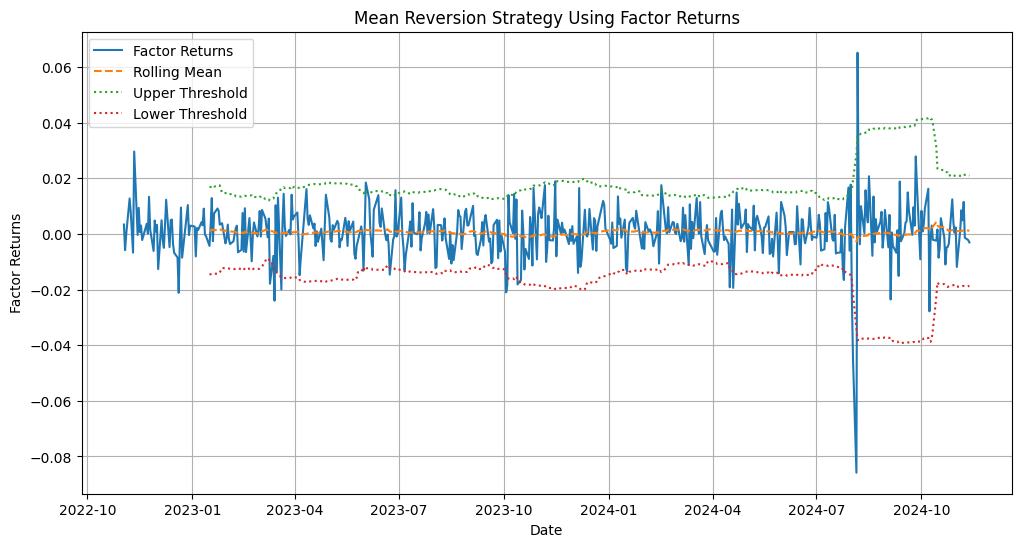

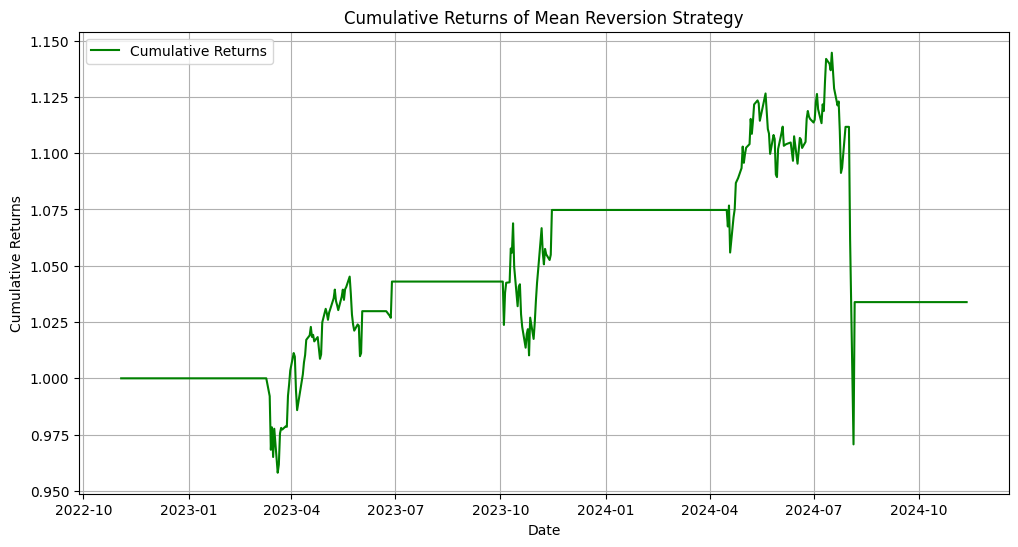

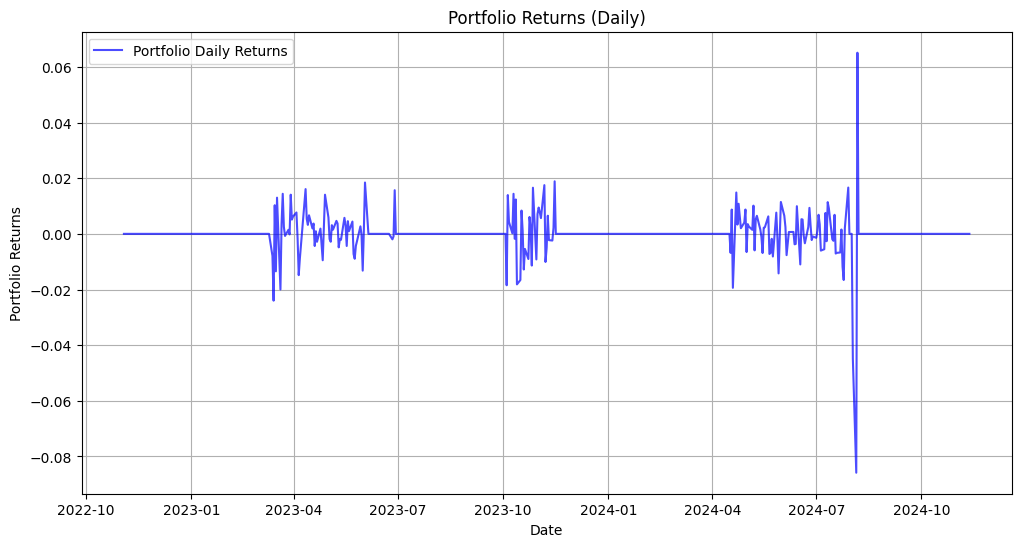

Performance Metrics:
Average Return: 0.0001
Standard Deviation: 0.0070
Sharpe Ratio: 0.0128


In [13]:
composite_result_50 = strategy_50.apply_strategy(composite_data, factor_column='Factor_Returns')

# Calculate cumulative returns for composite_result
composite_result_50['Cumulative_Returns'] = (1 + composite_result_50['Strategy_Returns']).cumprod()

# Plot the results for the composite returns
plotter = MeanReversionPlotter()
plotter.plot_results(composite_result_50, factor_column='Factor_Returns')

# Compute and print performance metrics for composite returns
avg_return = composite_result_50['Strategy_Returns'].mean()
std_dev = composite_result_50['Strategy_Returns'].std()
sharpe_ratio = avg_return / std_dev if std_dev != 0 else np.nan

performance_metrics = {
    "Average Return": avg_return,
    "Standard Deviation": std_dev,
    "Sharpe Ratio": sharpe_ratio
}

plotter.print_performance_metrics(performance_metrics)

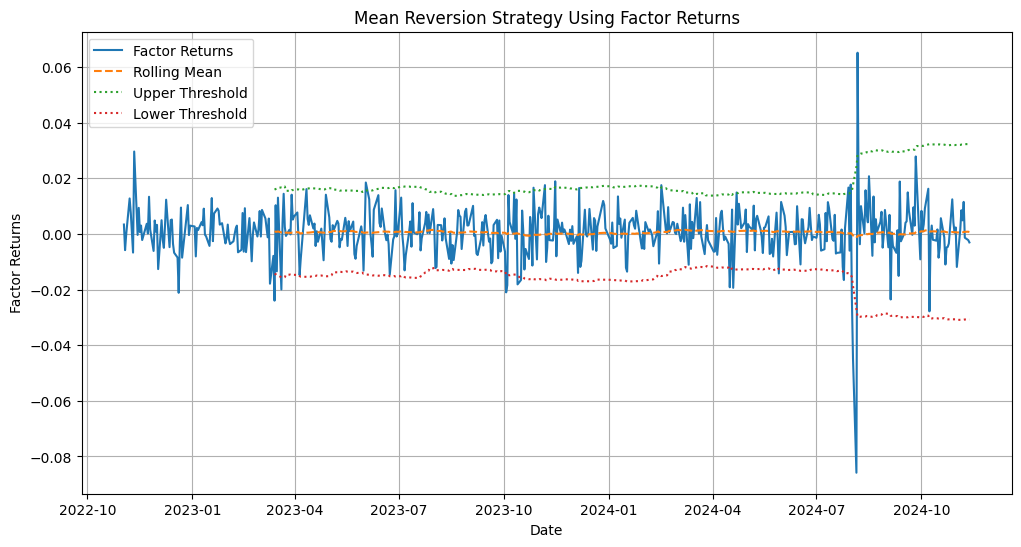

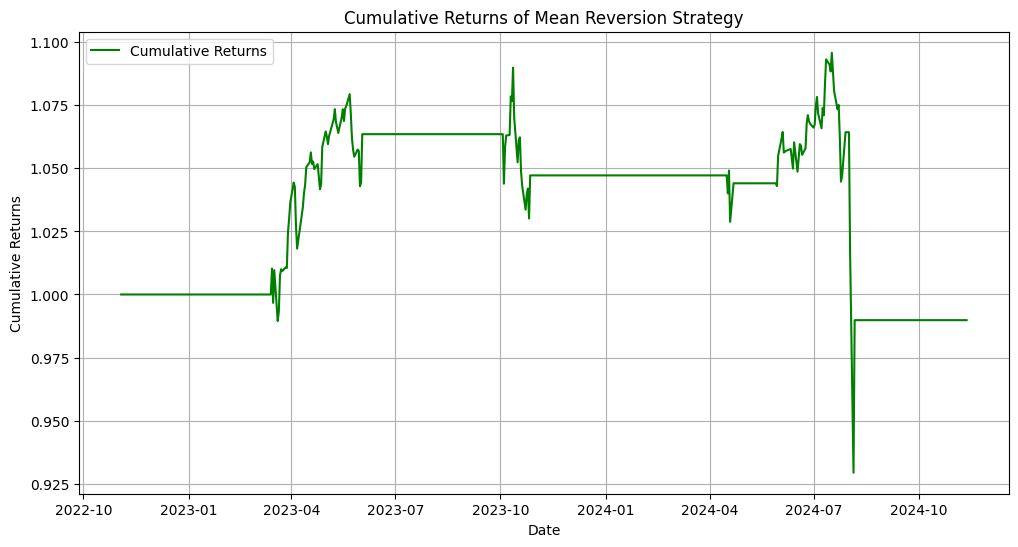

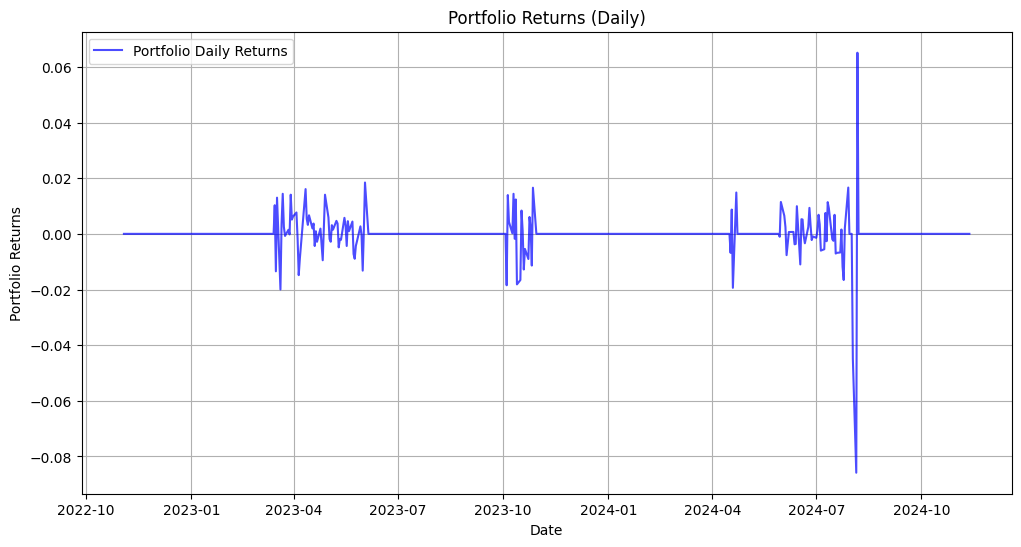

Performance Metrics:
Average Return: 0.0000
Standard Deviation: 0.0066
Sharpe Ratio: 0.0003


In [14]:
composite_result_90 = strategy_90.apply_strategy(composite_data, factor_column='Factor_Returns')

# Calculate cumulative returns for composite_result
composite_result_90['Cumulative_Returns'] = (1 + composite_result_90['Strategy_Returns']).cumprod()

# Plot the results for the composite returns
plotter = MeanReversionPlotter()
plotter.plot_results(composite_result_90, factor_column='Factor_Returns')

# Compute and print performance metrics for composite returns
avg_return = composite_result_90['Strategy_Returns'].mean()
std_dev = composite_result_90['Strategy_Returns'].std()
sharpe_ratio = avg_return / std_dev if std_dev != 0 else np.nan

performance_metrics = {
    "Average Return": avg_return,
    "Standard Deviation": std_dev,
    "Sharpe Ratio": sharpe_ratio
}

plotter.print_performance_metrics(performance_metrics)

In [15]:
strategy_20_1 = MeanReversionStrategy(window=20, k=2)
strategy_50_1 = MeanReversionStrategy(window=50, k=2)
strategy_90_1 = MeanReversionStrategy(window=90, k=2)

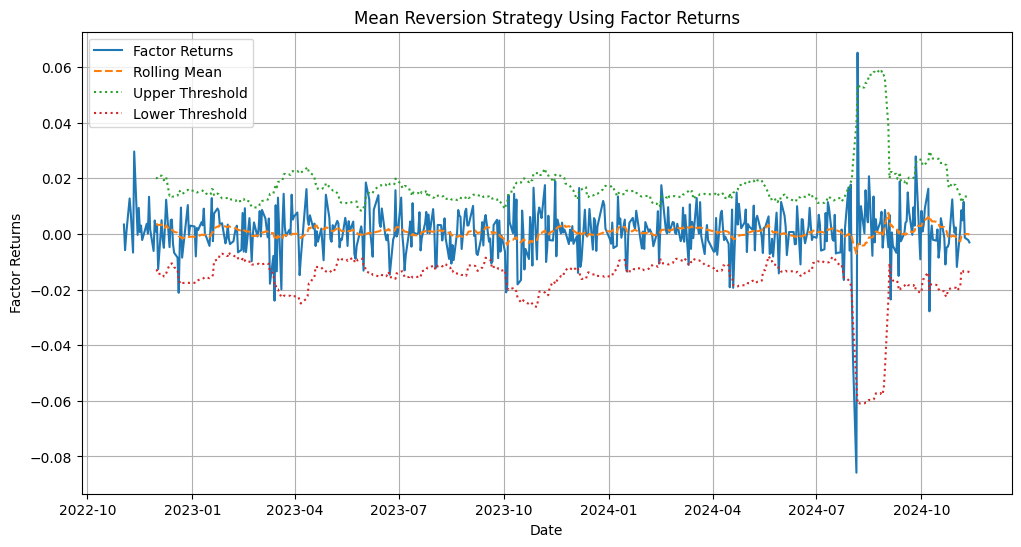

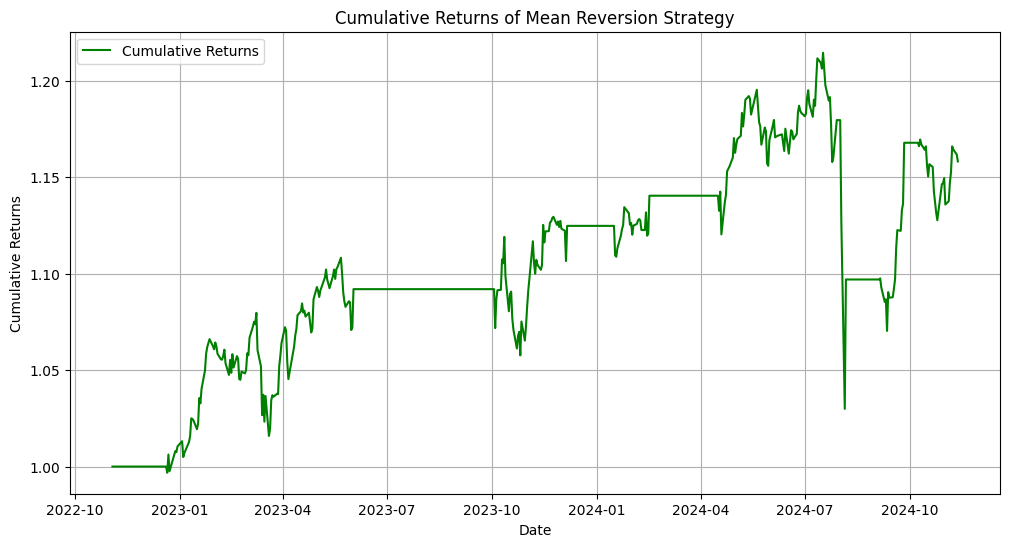

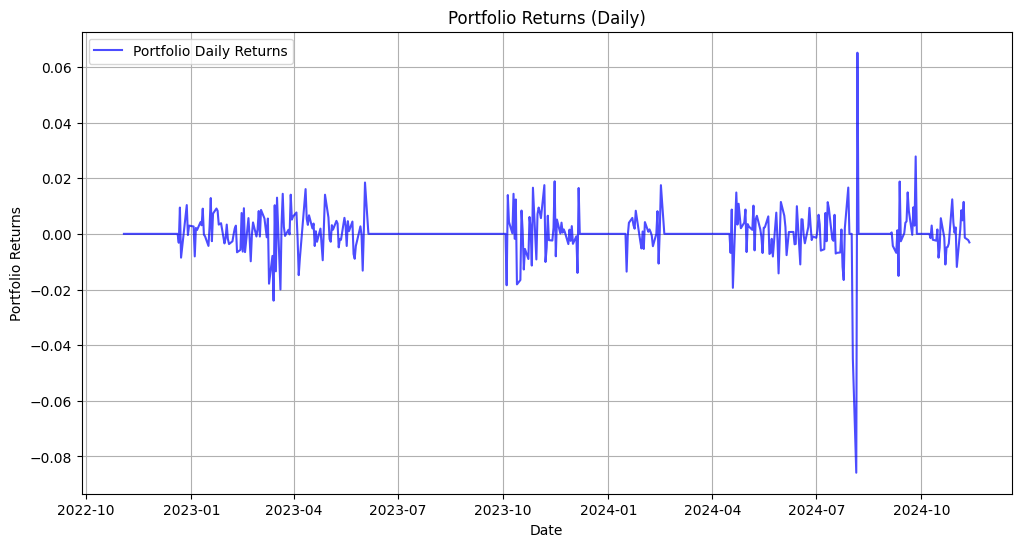

Performance Metrics:
Average Return: 0.0003
Standard Deviation: 0.0078
Sharpe Ratio: 0.0408


In [16]:
composite_result_20_1 = strategy_20_1.apply_strategy(composite_data, factor_column='Factor_Returns')

# Calculate cumulative returns for composite_result
composite_result_20_1['Cumulative_Returns'] = (1 + composite_result_20_1['Strategy_Returns']).cumprod()

# Plot the results for the composite returns
plotter = MeanReversionPlotter()
plotter.plot_results(composite_result_20_1, factor_column='Factor_Returns')

# Compute and print performance metrics for composite returns
avg_return = composite_result_20_1['Strategy_Returns'].mean()
std_dev = composite_result_20_1['Strategy_Returns'].std()
sharpe_ratio = avg_return / std_dev if std_dev != 0 else np.nan

performance_metrics = {
    "Average Return": avg_return,
    "Standard Deviation": std_dev,
    "Sharpe Ratio": sharpe_ratio
}

plotter.print_performance_metrics(performance_metrics)

### Russell 1000

In [17]:
russell_1000_returns = pd.read_csv("russell_1000_retuns.csv")
tickers_russell_1000 = pd.read_csv("tickers_russell_1000.csv")
tickers = tickers_russell_1000['Ticker']
russell_1000_returns.columns = ['Date'] + tickers.tolist()
russell_1000_returns['Date'] = pd.to_datetime(russell_1000_returns['Date'])

russell_1000_returns['Date'] = pd.to_datetime(russell_1000_returns['Date'])

russell_1000_returns['Composite_Returns'] = russell_1000_returns[tickers].mean(axis=1)
russell_1000_returns

,Date,NWS UW Equity,VRSK UW Equity,AA UN Equity,PFG UW Equity,VZ UN Equity,BA UN Equity,DOW UN Equity,SWCH UN Equity,RCL UN Equity,...,ORCL UN Equity,SATS UW Equity,1812209D UW Equity,SQ UN Equity,ZEN UN Equity,ST UN Equity,WDAY UW Equity,LIN UN Equity,AVT UW Equity,Composite_Returns
0,2019-11-01,0.004249,0.004561,0.051948,0.021918,-0.001654,0.015534,0.036047,-0.001354,0.021593,...,0.009360,0.007692,0.000137,0.019046,0.022364,0.007619,0.019549,0.002269,0.012386,0.013758
1,2019-11-04,0.003526,-0.034810,0.047554,0.015857,-0.008282,0.017092,0.035557,-0.016949,0.018888,...,0.008182,0.003053,-0.024521,-0.003514,-0.003738,0.024040,-0.000847,0.009859,0.028714,0.006819
2,2019-11-05,-0.002811,-0.010834,-0.013968,0.015429,-0.006180,0.020508,0.000554,0.027586,0.002030,...,0.003968,0.014206,-0.034265,-0.021161,-0.017371,0.015903,-0.023064,-0.002241,0.007767,-0.000051
3,2019-11-06,-0.014799,0.014411,-0.030544,0.000711,0.010588,-0.011443,0.001476,-0.024161,-0.006431,...,0.000539,-0.011006,-0.025156,0.004586,-0.005515,0.002982,0.001053,0.004044,-0.011802,-0.003118
4,2019-11-07,-0.013591,-0.006961,0.030137,-0.007991,0.006652,0.014611,0.028003,-0.000688,0.019596,...,0.005027,0.039454,0.039678,0.050049,-0.006826,-0.003530,-0.006871,0.007359,0.020229,0.002329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020-10-26,-0.023004,-0.019868,-0.034892,-0.035155,-0.002588,-0.039018,-0.028436,0.001935,-0.096465,...,-0.040234,-0.029423,0.000000,-0.038921,-0.019866,-0.013497,-0.061613,-0.026807,-0.043652,-0.023217
248,2020-10-27,-0.017656,-0.001833,0.002308,-0.062874,-0.007437,-0.034758,-0.012300,-0.027656,-0.015105,...,-0.007132,-0.044488,0.000000,0.006651,0.000463,-0.080638,0.018257,-0.011053,-0.018485,-0.012457
249,2020-10-28,-0.035209,-0.030570,-0.051420,-0.027953,-0.018647,-0.045738,-0.029849,-0.030423,-0.074242,...,-0.026104,-0.051916,0.000000,-0.022746,-0.036818,-0.022999,-0.020871,-0.037965,-0.042659,-0.029571
250,2020-10-29,0.006207,-0.001505,0.031553,0.022745,0.007991,0.001014,0.023683,0.004774,0.013365,...,0.007736,0.012603,0.000000,0.016335,0.018344,0.006693,0.037816,0.013508,-0.010036,0.011780


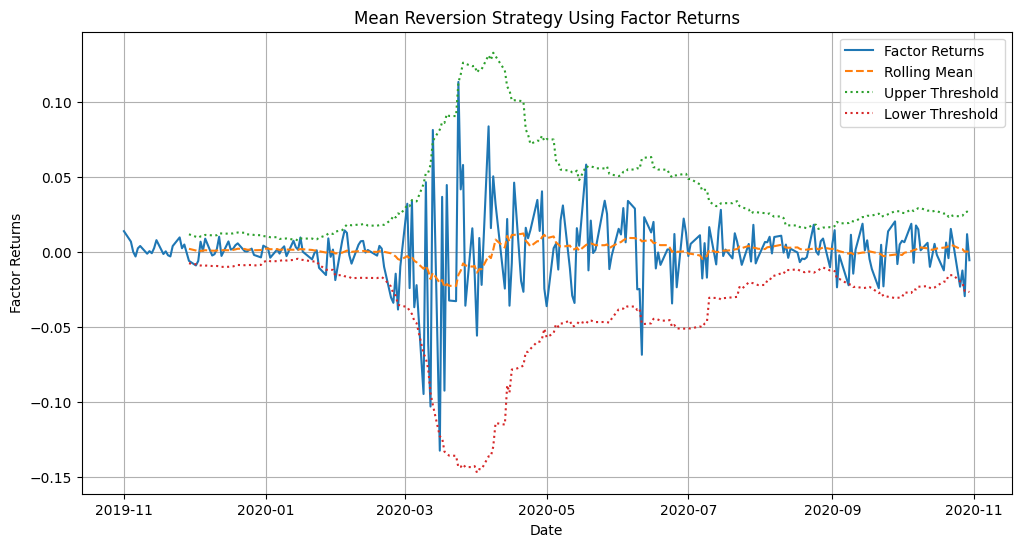

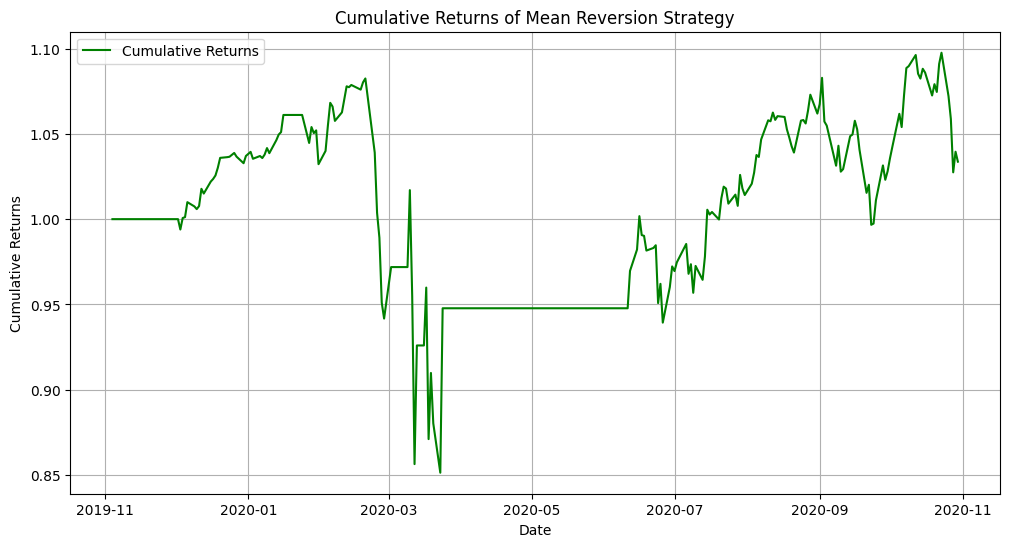

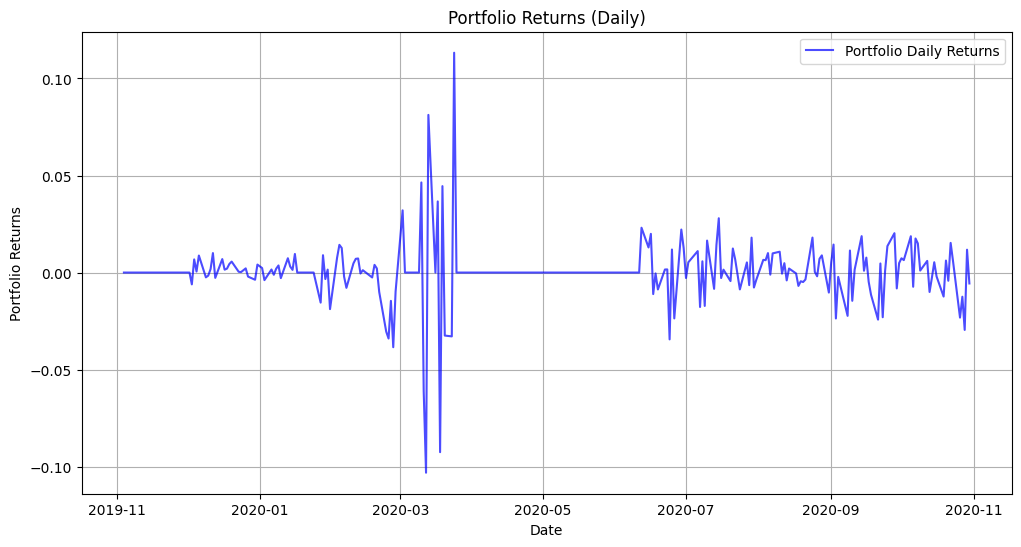

Performance Metrics:
Average Return: 0.0003
Standard Deviation: 0.0170
Sharpe Ratio: 0.0163


In [19]:
composite_data_russell_20 = russell_1000_returns[['Date', 'Composite_Returns']].dropna()
composite_data_russell_20.columns = ['Date', 'Factor_Returns']  

composite_result_russell_20 = strategy_20.apply_strategy(composite_data_russell_20, factor_column='Factor_Returns')

composite_result_russell_20['Cumulative_Returns'] = (1 + composite_result_russell_20['Strategy_Returns']).cumprod()

plotter.plot_results(composite_result_russell_20, factor_column='Factor_Returns')

# Compute and print performance metrics for composite returns
avg_return = composite_result_russell_20['Strategy_Returns'].mean()
std_dev = composite_result_russell_20['Strategy_Returns'].std()
sharpe_ratio = avg_return / std_dev if std_dev != 0 else np.nan

performance_metrics = {
    "Average Return": avg_return,
    "Standard Deviation": std_dev,
    "Sharpe Ratio": sharpe_ratio
}

plotter.print_performance_metrics(performance_metrics)